## Genereate Excel Report.

In [2]:
from openpyxl import load_workbook, Workbook
import os
import pickle
import pandas as pd
import numpy as np
from numpy import nan as NaN
import re
import math

In [20]:
csv_file = "Report/Aries/VTRepo_aries_v2.csv" # orig input
avDetecRateTh = 0.5 # keep >= 
md5FamilyRateTh = 0.1 # >=
df = pd.read_csv(csv_file, index_col = 0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (8,13,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
# ### make text-mining-based on VT report
token_dict = dict()
# delimiter is used for spliting tokens

delimiter = '\W+|\s+|\d+|.generic|generic.|multi.|troj.|.loader|.ware|.gen|gen.|.installer|unclassified.|' +'\,|!|\(|\)|\[|\]|@|:|/|\.|\_|\-|'

# general_string to remove
general_string = ['win32','trojan','adware','generic','application','variant','downloader','not-a-virus','downware',
                 'unwanted-program','heur','troj','bundler','antifw','riskware','optional','malware','behaveslike',
                 'kcloud','agent','trojandownloader','appl','trojware','installer','trojan-downloader','virus',
                 'backdoor','injector','malware-cryptor','dropper','cryptor','bundleapp','suspicious','antifwk',
                 'adinstaller','crypt','bundleinstaller','xpack', 'hacktool','patcher','troj_gen','grayware',
                 'software','install','click','heuristic','packed','unknown','applicunwnt','dropped','trojan-clicker',
                 'net-worm','monitoringtool','worm','tool','toolbar','eldorado','autorun','hw32', 'trojan-dropper',
                 'high', 'malicious', 'unwanted', 'potentially', 'win-trojan', 'oscope', 'inject', 'networm',
                 'p2p-worm', 'cloud', 'confidence', 'deepscan' , 'win64' , 'nsis', '100%' , 'gen7','hpeg','ransom','qvm01',
                  'qvm03','qvm05','qvm06','qvm10','qbm08','qvm11', 'qvm18','qvm19','qvm20','qvm42','generic2','generic5','generic6',
                  'trojan2','classic','ageneric', 'badfile', 'corruptfile','downloader11', 'genetic','program',
                  'suspected','generic3', 'signed', 'sgeneric', 'posible','download3','unclassifiedmalware','trojandropper',
                  'engine','proxy','qvod', 'suspectcrc', 'multitoolbar', 'trojanspy','tsgeneric','tspy','tsuploader','generickd',
                  'email','memscan','static', 'hfsa','small','download','core', 'file', 'shared','risk','adplugin','webtoolbar',
                  'hack','rootkit', 'auto',
                  'famvt']

# short family strings that should be kept
short_family_string = ['kdz', 'ipz', 'lmn']

import string
def is_hex(s):
    return all(c in string.hexdigits for c in s)

def tk_winnow(t):
    global token_dict
    if len(t) <= 3 and t not in short_family_string:
        return None
    elif t in general_string:
        return None
    elif is_hex(t):
        return None
    
    if t in token_dict:
        token_dict[t] += 1
    else:
        token_dict[t] = 1
    return t

def VT_winnow(s):

    if s is NaN: return NaN
    
    tokens = re.split(delimiter, str(s).lower())
    ret_tokens = list(filter(lambda x : x if x is not False else True, [tk_winnow(t) for t in tokens]))
    
    
    #Mike: 20171026
    if len(ret_tokens) > 1:
        return ret_tokens[0]
    else:
        return ret_tokens[0] if len(ret_tokens) != 0 else NaN

In [22]:
rows, cols = df.shape
null_ser = df.isnull().sum()/rows

In [23]:
df_nw = df.copy().applymap(VT_winnow)
av_drop_ser = (1.0 - null_ser >= avDetecRateTh) == False
filter_df = df_nw.copy()

for i in av_drop_ser.index:
    if av_drop_ser[i] == True:
        filter_df = filter_df.drop(i, axis = 1)

top3 = ['Microsoft', 'TrendMicro', 'Symantec']
# top3 = ['Microsoft', 'TrendMicro', 'Symantec']
wanna = [True if col in top3 else False for col in filter_df.columns]

vendors = pd.Series(wanna, index=filter_df.columns, dtype=bool)
top3_df = filter_df[filter_df.columns[vendors]]

top3_dropNA_df = top3_df.dropna(how='all')
print(top3_dropNA_df.shape)
top3_dropNA_df

C:\ProgramData\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


(8217, 3)


,Microsoft,Symantec,TrendMicro
0000e27a0471230eecf42e629d36b617c2726e26181b3a7e7e4c03097ae225e5,rogue,NaN,fakeav
0005abd8c992fb75fd3adf15055d578f72b1baff6d27e1c6bdc87b2315e6e9da,nabucur,reputation,virlock
000a14b757535a186d8d31912ab26491e2bb7ff3f15b9c21a1370dcafa50cacf,simda,NaN,cdaq
000a41796b190b9407bebd1431240540ab41738d91282e5901fb7331c5755b66,mabezat,mabezat,mabezat
000a5bfbae87ba7a9770c5f83c70cd1b2bc7a58b08d186a1d6ce295b4a1b020d,virtool,infostealer,tomb
000a6cc83da64715485e8279e45fdcdd8ca63f33d8d36b680a016e0770fbf39f,dorkbot,NaN,spnr
000a99b032a249de03ffc6c12290eb4cd007715c3e9147b6a5ca2235c58c3e97,NaN,sape,spnv
000b608dae150ae883eb0ed4d12a5e8d836405ae134be6060f4244ef7c6a4eee,creprote,NaN,NaN
000b7774e51d0a788917b6966fae175ddfd5e2051021fbf89a2380bad14793fd,NaN,reputation,NaN
000bfe5a6019cd8023396468440719401d66a25407d4163003e0d3afed0aab65,NaN,reputation,NaN


In [6]:
majorityDF = pd.DataFrame(columns=['Microsoft', 'Symantec', 'TrendMicro', 'Majority', 'SecondName', 'VoteRate'])
topAVFamilySamples = dict()  # k=familyName , val=md5 list
majority = []
voteRateList = []
secondFamList = []
nanCtr_dict = {0:0, 1:0, 2:0}
for md5, row in top3_dropNA_df.iterrows():
    rowCount = row.value_counts()
#     print(row.values)
    nanCtr = 0
    for val in row.values:
        if type(val) != str:
            nanCtr += 1
    nanCtr_dict[nanCtr] += 1
    
    if nanCtr < 2:
        family = np.nan
        if rowCount.tolist()[0] > 1:
            family = rowCount.keys().tolist()[0]
            if family not in topAVFamilySamples.keys():
                topAVFamilySamples[family] = list()
            topAVFamilySamples[family].append(md5)

            # check how many vendor vote the majority
            secName = np.nan
            if rowCount.tolist()[0] != 3 and nanCtr == 0:
                secName = rowCount.keys().tolist()[1]
            voteRate = rowCount.tolist()[0]
            
            myRow = row.tolist() + [family, secName, voteRate]
            majorityDF.loc[md5] = myRow
        else:
            family = np.nan
            voteRate = np.nan
            secName = np.nan
print(majorityDF.shape)
majorityDF

(2493, 6)


,Microsoft,Symantec,TrendMicro,Majority,SecondName,VoteRate
000a41796b190b9407bebd1431240540ab41738d91282e5901fb7331c5755b66,mabezat,mabezat,mabezat,mabezat,NaN,3
000c43f17cd5eb8d0fd7dc6f5de3dff995d14f593bb47e3df81accd46151aa92,allaple,rahack,allaple,allaple,rahack,2
000c9f0271594e28ad38c3ba13a4f02b38fb4e1e8e9d89ed9ebef72d7f7c784a,virut,virut,virux,virut,virux,2
0013cfe9466577a6b5dcf8727fb96582f66d9dc172a63a3c346df9c5eabde983,virut,virut,virux,virut,virux,2
0017abe3bfc7df3694c9daccf3571849ac5d6c1ee4bad8d8a27a68829b8b9c21,parite,NaN,parite,parite,NaN,2
001b43342d946305f449d1276b9025a6eba9391e6bc1e22eac65ea818b049f03,mydoom,mydoom,mydoom,mydoom,NaN,3
001bdb9eba33cedaff5c97b9f21cd480427aab45d37a565a55fc3793a40bf469,vobfus,changeup,vobfus,vobfus,changeup,2
001cd603d71bf35dfbc6ba7a71b254f70cb251f77ebb0564cfd3ebf77963a882,virut,virut,virux,virut,virux,2
001e40d6a7b3d52804a7cc130d96e70004b155b89b0a4422806ecf40969721fa,zbot,NaN,zbot,zbot,NaN,2
001e9174016e49196f0f205ffd653c8a9a458bb8ade46b76be81d8e4d25621a0,vobfus,changeup,vobfus,vobfus,changeup,2


In [7]:
_myDF = majorityDF[['Majority', 'VoteRate', 'SecondName']]

shortMD5_mapper = {md5:md5[0:6] for md5 in _myDF.index}
avVotingDF = _myDF.rename(shortMD5_mapper, axis='index')
avVotingDF

,Majority,VoteRate,SecondName
000a41,mabezat,3,NaN
000c43,allaple,2,rahack
000c9f,virut,2,virux
0013cf,virut,2,virux
0017ab,parite,2,NaN
001b43,mydoom,3,NaN
001bdb,vobfus,2,changeup
001cd6,virut,2,virux
001e40,zbot,2,NaN
001e91,vobfus,2,changeup


In [8]:
allvendor = 'Report/Aries/suggestFamily.pickle'
multi_second_fam = dict()
with open(allvendor, 'rb') as f:
    suggestFamily = pickle.load(f)
    f.close()
for k, v in suggestFamily.items():
    multi_second_fam[k[0:6]] = v
for sha in avVotingDF.index:
    if sha in multi_second_fam.keys():
        avVotingDF.loc[sha, 'multiFamilies'] = multi_second_fam[sha]
print(avVotingDF.shape)
avVotingDF

(2493, 4)


,Majority,VoteRate,SecondName,multiFamilies
000a41,mabezat,3,NaN,[mabezat]
000c43,allaple,2,rahack,[allaple]
000c9f,virut,2,virux,"[virut, virtob]"
0013cf,virut,2,virux,"[virut, virtob]"
0017ab,parite,2,NaN,[parite]
001b43,mydoom,3,NaN,[mydoom]
001bdb,vobfus,2,changeup,"[vbkrypt, vobfus]"
001cd6,virut,2,virux,"[virut, virtob]"
001e40,zbot,2,NaN,[zbot]
001e91,vobfus,2,changeup,"[vobfus, barys]"


In [10]:
def setReportMeta(groundTruth, processList, reportDF, avVotingDF):
    for proc in processList:
        hashVal = proc.split('_')[0]
        reportDF.loc[proc] = [myGen, groundTruth,
                              avVotingDF.loc[hashVal, 'SecondName'],
                              avVotingDF.loc[hashVal, 'multiFamilies'],
                              np.nan]
    return reportDF
        
def setDetectInfo(processList, threshold, familyPaths, groundTruth):
    familyNames = [f.split('/')[-1].split('_')[1].split('.')[0] for f in familyPaths]
    familyNames_scores = [f+' Score' for f in familyNames]
    detectDF = pd.DataFrame(columns=familyNames_scores + familyNames)
    detectDF.index.name='Process'
    detectDF['PredictLabel'] = np.nan
    detectDF['MaxScore'] = np.nan
    cols = list(detectDF.columns)
    cols = cols[-2:] + cols[:-2]
    detectDF = detectDF[cols]
    detectDF, procTruthScore = setScorebox(detectDF, threshold, processList, groundTruth, familyNames)
    return detectDF, procTruthScore
    
def setScorebox(detectDF, threshold, processList, groundTruth, familyNames):
    import math
    procTruthScore = dict()
    
    for proc in processList:
        treeNames = sorted(score_dict[proc].keys())
        familyScore = {fName:[] for fName in familyNames}
        normalizedResult = dict()

        for tr in treeNames:
            fName = tr.split('_')[0]
            if fName in ignoreFamilys:
                continue
            trName = tr.split('_')[2]
            trScore, commSeq = score_dict[proc][tr]
            familyScore[fName].append(str(trScore))

            # weigth
            weight, modelLength, memberCount = weight_dict[fName][trName]
            if modelLength > 10 and memberCount > 2:
                if fName not in normalizedResult.keys():
                    normalizedResult[fName] = dict()
                normalizedResult[fName][trName] = (trScore/modelLength, str(trScore), str(modelLength))
            
        argMax_original_len_dict = dict()
        argMax_dict = { fam:0 for fam in normalizedResult.keys()}
        for fam, treeScores in normalizedResult.items():
            for tr, trScore in treeScores.items():
                weight, modelLength, memberCount = weight_dict[fam][tr]
                if trScore[0] >= argMax_dict[fam]:
                    argMax_dict[fam] = trScore[0]
                    argMax_original_len_dict[fam] = trScore[1] + '/' + trScore[2]

        row = []
        predLabel = max(argMax_dict, key=argMax_dict.get)
        if argMax_dict[predLabel] < threshold:
            row.append("undecided_" + predLabel)
        else:
            if predLabel != groundTruth and argMax_dict[predLabel] == argMax_dict[groundTruth]:
                predLabel = groundTruth
            row.append(predLabel)
        predScore = (math.floor(argMax_dict[predLabel]*100)) / 100
        predScore = argMax_original_len_dict[predLabel] + '=' +"{0:.2f}".format(predScore)
        row.append(predScore)

        for k in sorted(familyScore.keys()): # add normalized family score
            score = "{0:.2f}".format(argMax_dict[k])
            row.append(argMax_original_len_dict[k] + '=' + score)

        for k in sorted(familyScore.keys()): # add original family score
            row.append(str(familyScore[k]))

        detectDF.loc[proc] = row
        # floor to 2 decimal digits
        truthScore = (math.floor(argMax_dict[groundTruth]*100)) / 100
        truthScore = argMax_original_len_dict[groundTruth] + '=' +"{0:.2f}".format(truthScore)
        procTruthScore[proc] = truthScore
        
    return detectDF, procTruthScore

In [6]:
%run CollectForestInfo.ipynb

base_dir = "output/top3_party_0622/"
familyDirs = [base_dir+f+'/' for f in os.listdir(base_dir)]

rasmmaModel_dict = dict()
weight_dict = dict()
ignoreFamilys = set()

for fam in familyDirs:
    pickleDir = fam + 'pickle/'
    tag = pickleDir.split('/')[-3]
    interPkl = pickleDir + tag + "_intermediate.pickle"
    residualPkl = pickleDir + tag + "_residual.pickle"

    forestInfo = CollectForestInfo(interPkl,
                           residualPkl,
                           True) # one pickle is a forest
    
    forestMemberCount = forestInfo.getForestMemberCount()
    weight_dict[tag.split("_")[0]] = dict()
    for treeName in forestInfo.getTreeRootNameList():
        labelName = tag+'_'+treeName
        memberCount = len(forestInfo.getTreeMembers(treeName))
        repSeq = forestInfo.getRepAPISeq(treeName)

        rasmmaModel_dict[labelName] = (memberCount/forestMemberCount, repSeq)
        weight_dict[tag.split("_")[0]][treeName] = (memberCount/forestMemberCount, len(repSeq), memberCount)
        
for fName, trs in weight_dict.items():
    save = False
    for tr, info in trs.items():
        if info[1] > 10 and info[2] > 2:
            save = True
            break
    if not save:
        ignoreFamilys.add(fName)
    
print("=== Finish building model ===")

=== Finish building model ===


In [12]:
result_output_dir = "output/testingResult/11939_0622_top3/global_align/"
threshold = 0.5

familyDirs = [result_output_dir+d for d in os.listdir(result_output_dir)]
shadowFamDirs = []
for f in familyDirs:
    if f.split('/')[-1].split('_')[1].split('.')[0] not in ignoreFamilys:
        shadowFamDirs.append(f)
familyDirs = shadowFamDirs 

titleRow = ["Process", "GroundTruthLabel", "OtherPossibleLabel",
            "Multi-Labels", "Test Score for Ground Truth Label"]
# titleRow = ["Process", "Generation", "Ground Truth Label", "Voting Rate", "Test Score for Ground Truth Label", "ESET-Label"]
titleRow += [f.split('/')[-1].split('_')[1].split('.')[0] for f in familyDirs]
dfList = list()

for famPath in familyDirs:
    
    reportDF = pd.DataFrame(columns=titleRow[1:5])
    reportDF.index.name=titleRow[0]
    
    with open(famPath, 'rb') as fHandle:
        score_dict = pickle.load(fHandle)
        fHandle.close()
        
    groundTruth = famPath.split('/')[-1].split('_')[1].split('.')[0]
    processList = sorted(score_dict.keys())
    reportDF = setReportMeta(groundTruth, processList, reportDF, avVotingDF)
    
    scoreboxDF, procTruthScore = setDetectInfo(processList,
                                               threshold,
                                               familyDirs,
                                               groundTruth)
    for proc, score in procTruthScore.items():
        reportDF.loc[proc, 'Test Score for Ground Truth Label'] = score
    reportDF = pd.concat([reportDF, scoreboxDF], axis=1)

    dfList.append(reportDF)
    
resultDF = pd.concat(dfList)
print(resultDF.shape)
resultDF

(410, 63)


,Generation,GroundTruthLabel,OtherPossibleLabel,Multi-Labels,Test Score for Ground Truth Label,PredictLabel,MaxScore,allaple Score,almanahe Score,berbew Score,...,ramnit,sality,shodi,upatre,valla,vflooder,virut,vobfus,wapomi,zbot
Process,,,,,,,,,,,,,,,,,,,,,
003777_3308,Main,allaple,rahack,"[allaple, rahack]",11/18=0.61,allaple,11/18=0.61,11/18=0.61,9/30=0.30,6/26=0.23,...,"['7', '15', '11', '15', '2', '8', '8', '424', ...","['6', '5', '2', '27', '4', '28', '9', '20', '2...","['5', '1', '7', '5', '7']","['16', '22', '16', '18', '7', '14']","['9', '19', '5', '10', '0']",['10'],"['15', '14', '15', '19', '5', '26', '22', '9',...","['15', '11', '14', '0', '3', '5', '7', '14', '...","['10', '7', '3', '16']","['7', '9', '9', '9', '15', '7', '11', '17', '1..."
003777_3328,2Gen,allaple,rahack,"[allaple, rahack]",7/13=0.53,ramnit,29/29=1.00,7/13=0.54,8/30=0.27,7/26=0.27,...,"['8', '5', '0', '9', '2', '29', '16', '8', '7'...","['5', '7', '2', '0', '2', '6', '9', '13', '8',...","['2', '3', '8', '2', '9']","['8', '10', '7', '7', '9', '8']","['9', '12', '6', '9', '0']",['9'],"['10', '0', '8', '0', '8', '11', '8', '9', '9'...","['9', '9', '9', '1', '2', '7', '5', '9', '9', ...","['9', '9', '1', '8']","['9', '9', '8', '8', '9', '9', '10', '7', '9',..."
003777_3388,3Gen,allaple,rahack,"[allaple, rahack]",6/13=0.46,ramnit,28/28=1.00,6/13=0.46,8/30=0.27,6/26=0.23,...,"['8', '6', '1', '8', '1', '16', '28', '8', '6'...","['5', '7', '1', '1', '2', '6', '9', '17', '8',...","['2', '2', '8', '2', '9']","['7', '11', '8', '7', '9', '7']","['9', '13', '6', '9', '0']",['10'],"['10', '0', '8', '0', '8', '12', '9', '9', '9'...","['8', '8', '9', '0', '2', '7', '5', '9', '8', ...","['9', '9', '1', '8']","['8', '8', '7', '8', '8', '8', '9', '7', '9', ..."
003777_3448,4Gen,allaple,rahack,"[allaple, rahack]",56/56=1.00,allaple,56/56=1.00,56/56=1.00,6/30=0.20,8/26=0.31,...,"['5', '5', '0', '7', '1', '6', '6', '15', '6',...","['9', '6', '1', '7', '4', '6', '13', '70', '94...","['3', '1', '62', '3', '62']","['10', '11', '81', '82', '6', '8']","['7', '14', '5', '63', '0']",['78'],"['7', '7', '9', '7', '6', '8', '6', '13', '8',...","['7', '7', '6', '0', '2', '6', '8', '6', '5', ...","['63', '62', '1', '8']","['5', '63', '60', '63', '7', '5', '7', '79', '..."
04300b_3288,Main,allaple,rahack,[allaple],56/56=1.00,allaple,56/56=1.00,56/56=1.00,8/30=0.27,8/26=0.31,...,"['8', '5', '1', '7', '2', '12', '11', '7', '6'...","['5', '7', '2', '1', '2', '6', '9', '65', '65'...","['2', '3', '82', '2', '77']","['10', '10', '63', '63', '9', '10']","['9', '12', '6', '64', '0']",['65'],"['10', '1', '8', '1', '8', '11', '7', '9', '7'...","['7', '7', '10', '1', '2', '8', '5', '10', '9'...","['64', '77', '1', '9']","['9', '64', '59', '62', '7', '9', '8', '62', '..."
04300b_3324,2Gen,allaple,rahack,[allaple],56/56=1.00,allaple,56/56=1.00,56/56=1.00,9/30=0.30,6/26=0.23,...,"['7', '5', '1', '8', '1', '9', '9', '9', '5', ...","['5', '7', '1', '3', '1', '5', '8', '64', '66'...","['1', '2', '76', '1', '77']","['9', '10', '65', '65', '8', '9']","['10', '10', '6', '66', '0']",['67'],"['12', '2', '8', '2', '8', '10', '7', '8', '9'...","['8', '8', '10', '0', '4', '8', '3', '10', '7'...","['66', '77', '1', '9']","['7', '65', '60', '64', '8', '7', '9', '64', '..."
04300b_3340,2Gen,allaple,rahack,[allaple],56/56=1.00,allaple,56/56=1.00,56/56=1.00,8/30=0.27,6/26=0.23,...,"['7', '5', '1', '7', '1', '9', '9', '8', '5', ...","['5', '7', '1', '2', '1', '5', '8', '64', '66'...","['1', '2', '76', '1', '77']","['9', '9', '64', '64', '8', '9']","['9', '9', '6', '65', '0']",['66'],"['11', '1', '8', '1', '8', '9', '7', '8', '8',...","['7', '7', '10', '0', '3', '8', '3', '10', '7'...","['65', '77', '1', '9']","['7', '64', '59', '63', '7', '7', '8', '63', '..."
04300b_3356,2Gen,allaple,rahack,[allaple],56/56=1.00,allaple,56/56=1.00,56/56=1.00,7/30=0.23,6/26=0.23,...,"['7', '5', '1', '6', '1', '9', '9', '7', '5', ...","['5', '7', '1', '1', '1', '5', '8', '64', '65'...","['1', '2', '76', '1', '77']","['9', '9', '6

In [13]:
for proc in resultDF.index:
    groundTruth = resultDF.loc[proc, "GroundTruthLabel"]
    predLabel = resultDF.loc[proc, "PredictLabel"]
    if predLabel.startswith('undecided'):
        resultDF.loc[proc, 'Result'] = 'undecided'
        resultDF.loc[proc, 'PredictLabel'] = predLabel.split('_')[1]
    elif predLabel != groundTruth:
        resultDF.loc[proc, 'Result'] = 'mismatch'
    else:
        resultDF.loc[proc, 'Result'] = 'match'
        
cols = list(resultDF.columns)

# move columns' index
cols = cols[0:1] + cols[-1:] + cols[1:2] + cols[4:7] + cols[2:4] + cols[7:-1] 
resultDF = resultDF[cols]
outputCol = [i for i in range(36)] # col index list (skip unwanted columns)
resultDF = resultDF[resultDF.columns[outputCol]]
print(resultDF.shape)
resultDF

(410, 36)


,Generation,Result,GroundTruthLabel,Test Score for Ground Truth Label,PredictLabel,MaxScore,OtherPossibleLabel,Multi-Labels,allaple Score,almanahe Score,...,ramnit Score,sality Score,shodi Score,upatre Score,valla Score,vflooder Score,virut Score,vobfus Score,wapomi Score,zbot Score
Process,,,,,,,,,,,,,,,,,,,,,
003777_3308,Main,match,allaple,11/18=0.61,allaple,11/18=0.61,rahack,"[allaple, rahack]",11/18=0.61,9/30=0.30,...,7/15=0.47,6/11=0.55,5/26=0.19,14/35=0.40,0/60=0.00,10/633=0.02,11/18=0.61,16/29=0.55,16/46=0.35,7/31=0.23
003777_3328,2Gen,mismatch,allaple,7/13=0.53,ramnit,29/29=1.00,rahack,"[allaple, rahack]",7/13=0.54,8/30=0.27,...,29/29=1.00,5/11=0.45,9/77=0.12,8/35=0.23,0/60=0.00,9/633=0.01,7/13=0.54,9/31=0.29,8/46=0.17,9/31=0.29
003777_3388,3Gen,mismatch,allaple,6/13=0.46,ramnit,28/28=1.00,rahack,"[allaple, rahack]",6/13=0.46,8/30=0.27,...,28/28=1.00,5/11=0.45,9/77=0.12,7/35=0.20,0/60=0.00,10/633=0.02,6/13=0.46,8/31=0.26,8/46=0.17,8/31=0.26
003777_3448,4Gen,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,"[allaple, rahack]",56/56=1.00,6/30=0.20,...,9/11=0.82,9/11=0.82,62/77=0.81,8/35=0.23,0/60=0.00,78/633=0.12,56/56=1.00,62/100=0.62,62/77=0.81,63/73=0.86
04300b_3288,Main,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,[allaple],56/56=1.00,8/30=0.27,...,77/77=1.00,82/101=0.81,77/77=1.00,10/35=0.29,0/60=0.00,65/633=0.10,72/72=1.00,81/100=0.81,77/77=1.00,62/73=0.85
04300b_3324,2Gen,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,[allaple],56/56=1.00,9/30=0.30,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,67/633=0.11,72/72=1.00,75/100=0.75,77/77=1.00,64/73=0.88
04300b_3340,2Gen,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,[allaple],56/56=1.00,8/30=0.27,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,66/633=0.10,72/72=1.00,75/100=0.75,77/77=1.00,63/73=0.86
04300b_3356,2Gen,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,[allaple],56/56=1.00,7/30=0.23,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,65/633=0.10,72/72=1.00,75/100=0.75,77/77=1.00,62/73=0.85
047252_2852,Main,match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,"[allaple, rahack]",56/56=1.00,8/30=0.27,...,77/77=1.00,82/101=0.81,77/77=1.00,10/35=0.29,0/60=0.00,65/633=0.10,72/72=1.00,81/100=0.81,77/77=1.00,62/73=0.85


In [3]:
# calculate profile's maximum score in each family
def profileScoreInEachFamily(profileScoreInFamilyBTs):
    profileFamilyScores = dict()
    for proc, familyBTScores in profileScoreInFamilyBTs.items():

        profileFamilyScores[proc] = dict()
        for familyName, profileBTScores in familyBTScores.items():
            if familyName not in profileFamilyScores[proc].keys():
                profileFamilyScores[proc][familyName] = (0,0,0)

            for profileBTScore in profileBTScores:
                maxScore, maxGSALen, maxScoreModel = profileFamilyScores[proc][familyName]
                score, gsaLen, modelLen = profileBTScore
                if float(score) > float(maxScore):
                    profileFamilyScores[proc][familyName] = (score, gsaLen, modelLen)
                elif float(score) == float(maxScore):
                    if gsaLen > maxGSALen:
                        profileFamilyScores[proc][familyName] = (score, gsaLen, modelLen)
    return profileFamilyScores

In [4]:
import pickle
import math

def createScoreBox(result_data_dir):
    scoreBox = pd.DataFrame()
    for resPkl in os.listdir(result_data_dir):
        truth = resPkl.split('_')[1].split('.')[0]
        with open(result_data_dir + resPkl, 'rb') as fHandle:
            result = pickle.load(fHandle)
            fHandle.close()
            
        processList = result.keys()
        profileScoreInFamilyBTs = dict()
        
        # calculate profile's score with each behavior tree
        # record with family name
        for proc in processList:
            familyBTScores = dict()
            BTNames = result[proc]
            for bt in BTNames:
                famName = bt.split('_')[0]
                if famName in ignoreFamilys: continue # skip unwanted family
                trName = bt.split('_')[2]
                gsaLen, commSeq = result[proc][bt]
                modelWeight, modelLength, modelMemberCount = weight_dict[famName][trName]
                
                # filter trees
                if modelLength > 10 and modelMemberCount > 2:
                    if famName not in familyBTScores.keys():
                        familyBTScores[famName] = list()
                        
                    profileInBT = gsaLen/modelLength # calculate gsa ratio score for bt
                    familyBTScores[famName].append((profileInBT, gsaLen, modelLength))
            profileScoreInFamilyBTs[proc] = familyBTScores
            
        # calculate profile's maximum score in each family
        profileFamilyScores = profileScoreInEachFamily(profileScoreInFamilyBTs)

        # record profile score of family to scorebox
        for proc, familyScores in profileFamilyScores.items():
            for famName, scoreInfo in familyScores.items():
                score, gsaLen, modelLen = scoreInfo
                score = (math.floor(score*100)) / 100
                outputSentence = str(gsaLen) +'/'+ str(modelLen) + '=' + str(score)
                scoreBox.loc[proc, famName+' Score'] = outputSentence
    return scoreBox

def assignGroundTruth(scoreBox, sample_truth_dict):
    for proc in scoreBox.index:
        shaName = proc.split('_')[0]
        scoreBox.loc[proc, 'GroundTruthLabel'] = truth_dict[shaName]
    return scoreBox

def getTruthScore(processScores, groundTruth):
    for pair in processScores:
        famName, score = pair
        if groundTruth == famName:
            return score
    return None # should not touch

def exactMatch(threshold, processScores, groundTruth):
    maxPair = processScores[0]
    maxScoreFamily, maxScore = maxPair
    
    if maxScore < threshold:
        return 3
    else:
        # if there are many equal maximum score, check whether truth in there.
        multi_max = set()
        for pair in processScores:
            famName, score = pair
            if score == maxScore:
                multi_max.add(famName)
#             else:
#                 break
        if groundTruth in multi_max:
            return 1 # match
        else:
            return 2 # mismatch

def effectiveMatch(threshold, processScores, groundTruth):
    maxPair = processScores[0]
    maxScoreFamily, maxScore = maxPair
    
    # prepare the prospective candidate set
    candidateSet = set()
    for pair in processScores:
        famName = pair[0]
        score = pair[1]
        if score >= threshold:
            candidateSet.add(famName)
            
    if len(candidateSet) == 0:
        return 3
    else:
        if groundTruth in candidateSet: return 1
        else: return 2

def getMatchResult(scoreBox, threshold, matchMethod):
    sample_scores = dict()
    sample_truth = dict()
    for procName, row in scoreBox.iterrows():
        sampleName = procName.split('_')[0]
        truthLabel = row['GroundTruthLabel']
        if sampleName not in sample_scores.keys():
            sample_scores[sampleName] = []
            sample_truth[sampleName] = truthLabel

        processScoreList = []
        for col in range(0,28):
            s_in_fam = float(row[col].split('=')[1])
            famName = scoreBox.columns[col].split(' ')[0]
            scorePair = (famName, s_in_fam)
            processScoreList.append(scorePair)
        sample_scores[sampleName].extend(processScoreList)

    sample_result = dict()
    matchResultTable = pd.DataFrame(columns = ['MatchType', 'PredictFamily', 'GroundTruth'])
    for key, val in sample_scores.items():
        truth = sample_truth[key]
        processScores = sorted(val, key=lambda x:x[1], reverse=True)
        maxPair = processScores[0]
        maxScoreFamily, maxScore = maxPair
        truthScore = getTruthScore(processScores, truth)

        # there are 'Exact-Match' and 'Effective-Match' method.
        # result: 1-match, 2-mismatch, 3-undecided
        if matchMethod == 'Effective_Match':
            matchResult = effectiveMatch(threshold, processScores, truth)
        elif matchMethod == 'Exact_Match':
            matchResult = exactMatch(threshold, processScores, truth)
            
        if matchResult == 1:
            matchResultTable.loc[key, 'MatchType'] = 'Match'
            matchResultTable.loc[key, 'PredictFamily'] = truth
            matchResultTable.loc[key, 'GroundTruth'] = truth
            matchResultTable.loc[key, 'MaxScore'] = maxScore
            matchResultTable.loc[key, 'TruthScore'] = truthScore
        else:
            matchResultTable.loc[key, 'PredictFamily'] = maxScoreFamily
            matchResultTable.loc[key, 'GroundTruth'] = truth
            matchResultTable.loc[key, 'MaxScore'] = maxScore
            matchResultTable.loc[key, 'TruthScore'] = truthScore
            if matchResult == 2:
                matchResultTable.loc[key, 'MatchType'] = 'Mismatch'
            else:
                matchResultTable.loc[key, 'MatchType'] = 'Undecided'

    return matchResultTable

In [8]:
resultDir = "output/omg_testing/11939_onlyone_detect/global_align/"
# resultDir = "output/testingResult/11939_0622_top3/global_align/"
baseScoreBox = createScoreBox(resultDir)

myDB = '11939data/no_consensus_one_detected/'
# myDB = '11939data/top3_party_thesis_test/'
testFamilies = os.listdir(myDB)
truth_dict = dict()
for famName in testFamilies:
    famPath = myDB + famName + '/'
    for trace in os.listdir(famPath):
        shaName = trace[0:6]
        truth_dict[shaName] = famName
        
scoreBox_withTruth = assignGroundTruth(baseScoreBox, truth_dict)

# matchMethod='Exact_Match' and 'Effective_Match'
matchResultTable = getMatchResult(scoreBox_withTruth, threshold=0.8, matchMethod='Effective_Match')

matchTypeStatistic = matchResultTable['MatchType'].value_counts()
matchCtr = matchTypeStatistic['Match']
mismatchCtr = matchTypeStatistic['Mismatch']
undecidedCtr = matchTypeStatistic['Undecided']
totalSamples = matchCtr + mismatchCtr + undecidedCtr
print(matchTypeStatistic)
print("Match Rate:", matchCtr/totalSamples)
matchResultTable

Match        27
Mismatch     26
Undecided    13
Name: MatchType, dtype: int64
Match Rate: 0.409090909091


,MatchType,PredictFamily,GroundTruth,MaxScore,TruthScore
0b0bc2,Undecided,allaple,berbew,0.61,0.19
0d4a1a,Mismatch,allaple,chir,1.00,0.39
3b720c,Match,expiro,expiro,1.00,0.98
0cc1fe,Undecided,allaple,fakeav,0.61,0.42
0d325e,Match,fakeav,fakeav,1.00,0.95
0dbd93,Match,fakeav,fakeav,1.00,0.95
00feef,Mismatch,allaple,mabezat,1.00,0.07
0efa91,Match,mydoom,mydoom,1.00,0.98
e86fcc,Match,parite,parite,1.00,1.00
1ce77e,Match,ramnit,ramnit,1.00,0.82


In [9]:
mismatchCtr = 0
for sampleName, row in matchResultTable.iterrows():
    matchType = row['MatchType']
    predictLabel = row['PredictFamily']
    truth = row['GroundTruth']
    
    multiLabels = set()
    processes = set()
    if matchType == 'Mismatch':
        mismatchCtr+=1
        print(mismatchCtr, sampleName, predictLabel, truth)
        for proc in resultDF.index:
            if proc.split('_')[0] == sampleName:
                processes.add(proc)
        for proc in processes:
            multiLabels.update(resultDF.loc[proc, 'Multi-Labels'])
            multiLabels.add(resultDF.loc[proc, 'OtherPossibleLabel'])
        if predictLabel in multiLabels:
            print("!!!")
        print(multiLabels)

1 0d4a1a allaple chir


NameError: name 'resultDF' is not defined

### Create Confusion Matrix and Do Evaluation
##### Calculate 'Precision', 'Recall', and 'F1'

In [154]:
family_confusion = dict()
for family in matchResultTable['GroundTruth'].values:
    if family not in family_confusion.keys():
        family_confusion[family] = {'TP':0, 'FP':0, 'TN':0, 'FN':0}

## create confusion matrix for each family
for sample, row in matchResultTable.iterrows():
    predictLabel = row['PredictFamily']
    truthLabel = row['GroundTruth']
    matchType = row['MatchType']
    
    if matchType == 'Undecided':
        family_confusion[truthLabel]['FN'] += 1
    else:
        if predictLabel == truthLabel:
            family_confusion[truthLabel]['TP'] += 1
        else:
            family_confusion[truthLabel]['FN'] += 1
            family_confusion[predictLabel]['FP'] += 1
        
    for famName in family_confusion.keys():
        if famName != truthLabel and famName != predictLabel:
            family_confusion[famName]['TN'] += 1
            
recalls = []
precisions = []
fs = []
for famName in sorted(family_confusion.keys()):
    matrix = family_confusion[famName]
    tp = matrix['TP']
    tn = matrix['TN']
    fp = matrix['FP']
    fn = matrix['FN']
    population = tp+tn+fp+fn
    
    if (tp+fp) != 0:
        precision = tp/(tp+fp)
    else:
        precision = 0.0
    recall = tp/(tp+fn)
    if recall!=0 and precision!=0:
        f1 = 2 / ((1/recall) + (1/precision))
    else:
        f1 = 0.0
        
    recalls.append("{0:.2f}".format(recall))
    precisions.append("{0:.2f}".format(precision))
    fs.append("{0:.2f}".format(f1))

### Create a dataframe table (dashboard)
evaTable = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
families = sorted(family_confusion.keys())
for idx in range(len(recalls)):
    evaTable.loc[families[idx]] = (precisions[idx], recalls[idx], fs[idx])

print(evaTable.shape)
evaTable

(28, 3)


,Precision,Recall,F1
allaple,0.74,0.96,0.83
almanahe,1.00,1.00,1.00
berbew,0.00,0.00,0.00
chir,1.00,0.33,0.50
eggnog,0.80,0.80,0.80
elkern,1.00,0.80,0.89
expiro,1.00,0.79,0.88
fakeav,1.00,0.80,0.89
fesber,0.00,0.00,0.00
ipamor,1.00,1.00,1.00


In [155]:
def averOfList(myList):
    mySum = 0
    for l in myList:
        mySum += float(l)
    return mySum/len(myList)

aver_precision = averOfList(precisions)
aver_recall = averOfList(recalls)
aver_f1 = averOfList(fs)
print("Average Precision:", aver_precision)
print("Average Recall:", aver_recall)
print("Average F1:", aver_f1)

Average Precision: 0.8017857142857141
Average Recall: 0.6660714285714285
Average F1: 0.7096428571428571


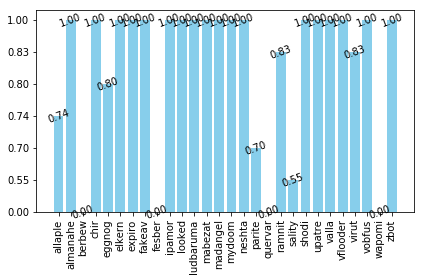

In [158]:
%matplotlib inline
import matplotlib.pyplot as plt

### Draw the visualization graph for precision/recall/f1
families = sorted(family_confusion.keys())
x = families
y = precisions ## precisions/recalls/fs
yinterval = 0.2
plt.bar(x, y, color='skyblue')
plt.xticks(rotation='vertical')
# plt.yticks([[0.0,0.2,0.4,0.6,0.8,1.0]])
# plt.ylim(0, 1)
plt.tight_layout()
for i in range(len(x)):
    plt.text(x=i-1, y=y[i], s=y[i], rotation=20)
# plt.show()
plt.savefig('Report/Aries/precisions_'+str(threshold)+'.png')

In [14]:
scoreDF = resultDF.copy()

match = 0
mis = 0
un = 0
blue = 0
green = 0
undecided_sameButLow = 0

seeAPI_procs = [] # 用來檢視其API在predict和ground truth是不是相差很多'個'
for hashVal, row in scoreDF.iterrows():
    res = row['Result']
    if res == 'match':
        match += 1
        scoreDF.loc[hashVal, 'Match_Type'] = 'exact_match'
    elif res == 'mismatch':
        mis += 1
        
        testScore = row['Test Score for Ground Truth Label']
        testScore = float(testScore.split('=')[1])
        if testScore >= 0.5:
            blue += 1
            scoreDF.loc[hashVal, 'Match_Type'] = 'TopN_match'
        else:
            green += 1
    else:
        un += 1
        
        predLabel = row['PredictLabel']
        truthLabel = row['GroundTruthLabel']
        if predLabel == truthLabel:
            undecided_sameButLow += 1
        else:
            seeAPI_procs.append((hashVal, truthLabel, predLabel))
#     if res == 'mismatch' or res == 'undecided':
#         secName = row['Other Possible Label']
#         multiLabels = row['Multi-Labels']
#         predLabel = row['PredictLabel']
#         testScore = row['Test Score for Ground Truth Label']
#         testScore = float(testScore.split('=')[1])
#         if predLabel == secName:
#             print("!!!!")
#         if testScore >= 0.8 and predLabel in multiLabels:
#             print("multi!! - ", predLabel, multiLabels, testScore)

print("match:",match, " mismatch:", mis, " Undecided:",un)
allSamples = match + mis + un
print(match+mis+un)
print("Blue:", blue)
print("Green:", green)
print("Accuracy Rate = ", match / allSamples)
print("include blue = ", (match + blue) / (allSamples))
print("Undecided but predit == ground truth :", undecided_sameButLow)

sdfcols = list(scoreDF.columns)
sdf_cols_idx = sdfcols[:2] + sdfcols[-1:] + sdfcols[2:-1]
scoreDF = scoreDF[sdf_cols_idx]
scoreDF

match: 242  mismatch: 153  Undecided: 15
410
Blue: 88
Green: 65
Accuracy Rate =  0.5902439024390244
include blue =  0.8048780487804879
Undecided but predit == ground truth : 7


,Generation,Result,Match_Type,Ground Truth Label,Test Score for Ground Truth Label,PredictLabel,MaxScore,Other Possible Label,allaple Score,almanahe Score,...,ramnit Score,sality Score,shodi Score,upatre Score,valla Score,vflooder Score,virut Score,vobfus Score,wapomi Score,zbot Score
Process,,,,,,,,,,,,,,,,,,,,,
003777_3308,Main,match,exact_match,allaple,11/18=0.61,allaple,11/18=0.61,rahack,11/18=0.61,9/30=0.30,...,7/15=0.47,6/11=0.55,5/26=0.19,14/35=0.40,0/60=0.00,10/633=0.02,11/18=0.61,16/29=0.55,16/46=0.35,7/31=0.23
003777_3328,2Gen,mismatch,TopN_match,allaple,7/13=0.53,ramnit,29/29=1.00,rahack,7/13=0.54,8/30=0.27,...,29/29=1.00,5/11=0.45,9/77=0.12,8/35=0.23,0/60=0.00,9/633=0.01,7/13=0.54,9/31=0.29,8/46=0.17,9/31=0.29
003777_3388,3Gen,mismatch,NaN,allaple,6/13=0.46,ramnit,28/28=1.00,rahack,6/13=0.46,8/30=0.27,...,28/28=1.00,5/11=0.45,9/77=0.12,7/35=0.20,0/60=0.00,10/633=0.02,6/13=0.46,8/31=0.26,8/46=0.17,8/31=0.26
003777_3448,4Gen,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,6/30=0.20,...,9/11=0.82,9/11=0.82,62/77=0.81,8/35=0.23,0/60=0.00,78/633=0.12,56/56=1.00,62/100=0.62,62/77=0.81,63/73=0.86
04300b_3288,Main,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,8/30=0.27,...,77/77=1.00,82/101=0.81,77/77=1.00,10/35=0.29,0/60=0.00,65/633=0.10,72/72=1.00,81/100=0.81,77/77=1.00,62/73=0.85
04300b_3324,2Gen,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,9/30=0.30,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,67/633=0.11,72/72=1.00,75/100=0.75,77/77=1.00,64/73=0.88
04300b_3340,2Gen,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,8/30=0.27,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,66/633=0.10,72/72=1.00,75/100=0.75,77/77=1.00,63/73=0.86
04300b_3356,2Gen,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,7/30=0.23,...,77/77=1.00,76/101=0.75,77/77=1.00,9/35=0.26,0/60=0.00,65/633=0.10,72/72=1.00,75/100=0.75,77/77=1.00,62/73=0.85
047252_2852,Main,match,exact_match,allaple,56/56=1.00,allaple,56/56=1.00,rahack,56/56=1.00,8/30=0.27,...,77/77=1.00,82/101=0.81,77/77=1.00,10/35=0.29,0/60=0.00,65/633=0.10,72/72=1.00,81/100=0.81,77/77=1.00,62/73=0.85


In [16]:
# seeAPI_procs

In [17]:
matchTypeCol = scoreDF['Match_Type']
for sha, row in scoreDF.iterrows():
    cell = row['Match_Type']
    if type(cell) != str:
        scoreDF.loc[sha, 'Match_Type'] = 'NaN'

wb = Workbook()
reportName = 'Report/0724_28family_' + result_output_dir.split('/')[-2] + '_RasMMA_0.5.xlsx'

sheet = wb.active
sheet.title = 'BT_Len>10 or profile>2'

titleRow = ['sha256','Process'] + scoreDF.columns.tolist()
sheet.append(titleRow)

sampleName = ''
for proc, row in scoreDF.iterrows():
    newSampleName = proc.split('_')[0]
    xlsxRow = []
    xlsxRow.extend([newSampleName, proc])
    xlsxRow.extend(row)
    sheet.append(xlsxRow)

wb.save(reportName)

In [ ]:
def outputScoreBox(reportName, scoreBox):
    wb = Workbook()
    sheet = wb.active
    titleRow = ['ProcessName']
    titleRow.extend(scoreBox.columns)
    titleRow.insert(0,'SHA256')
    sheet.append(titleRow)

    for proc, row in scoreBox.iterrows():
        newRow = []
        sha = proc.split('_')[0]
        newRow.append(sha)
        newRow.append(proc)
        for c in row:
            newRow.append(str(c))
        sheet.append(newRow)

    wb.save(reportName)
    print("Finish Output.")

reportName = 'Report/0726_28family_0.8_exact_match.xlsx'
outputScoreBox(reportName=reportName, scoreBox=scoreBox_withTruth)